# **ExpressGen**

Farah Salhany

## **Abstract**

This project aims to address the challenge of neutral or disengaged
appearances in virtual conference calls by subtly transforming facial
expressions while preserving identity. The approach involves taking an input image from a virtual meeting (often featuring a neutral or disengaged expression) and generating a minimally altered version that conveys a more engaging demeanor, such as a gentle smile or a more attentive gaze. The model will be trained on diverse facial expression datasets like AffectNetHQ [2] and CelebA HQ [3], ensuring robust learning from a variety of natural expressions. The primary method employs StarGAN v2 for multi-domain image-to-image translation using unpaired data.

The quality of the generated expressions will be evaluated through Frechet Inception Distance (FID) to ensure realism and a face-recognition embedding distance to verify identity retention along with human assessments to verify that the modifications are both subtle and impactful.

In addition, the project will address challenges common to generative models, such as mode collapse and dataset imbalances, by employing techniques like gradient penalty, mini-batch discrimination, and data augmentation.

By adapting StarGAN v2 to this virtual conference context, the project offers a novel approach to improving remote communication experiences.


## **Introduction**

## **Methodology**

## **Experimental Setup**

- **Imports of required packages**

In [1]:
import os
import sys
import gc
import importlib
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

from munch import Munch
from datetime import datetime
print(datetime.now())

2025-04-25 00:43:38.920668


In [2]:
sys.path.append('..')
from data import download_affectnethq, dataloader, dataset_analysis
from model import model
#from src import train

%load_ext autoreload
%autoreload 2

- **System Information**

In [3]:
print("Current path:")
!pwd
python_path = sys.executable
print("Python path: ", python_path)
print("Using python", sys.version)
print("Using torch", torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device, "[",torch.cuda.get_device_name(0),"]")

Current path:
/nfs/speed-scratch/f_salha/comp6841/ExpressGen/notebooks
Python path:  /speed-scratch/f_salha/comp6841/envs/ExpressGen_env/bin/python
Using python 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
Using torch 2.6.0+cu118
Using device: cuda:0 [ NVIDIA A100-SXM4-80GB MIG 7g.80gb ]


### Dataset Setup and Analysis

**Datasets used in this project:**
* AffectNetHQ by Piro17: available on Hugging Face [Piro17/affectnethq](https://huggingface.co/datasets/Piro17/affectnethq). The dataset contains high-quality facial images capturing a diverse range of emotions.

In [4]:
# Check if dataset exists in `data/affectnethq` else download it.
if not os.path.exists("../data/affectnethq"):
    print("Dataset not found. Downloading AffectNetHQ...")
    download_affectnethq.download_and_organize_affectnethq()  
else:
    print("Dataset already exists. Skipping download.")

#!ls -lah ../data/affectnethq

Dataset already exists. Skipping download.


In [5]:
# If needed, copy the data from NFS to local storage on the node
# !rsync -avP os.path.exists("../data/affectnethq") /nobackup/
# !rsync -avzP os.path.exists("../data/affectnethq") /nobackup/

**Dataset Analysis**\
The AffectNetHQ dataset contains high-quality facial images labeled with seven expression classes:
- Anger
- Disgust
- Fear
- Happy
- Neutral
- Sad
- Surprise

We analyze the AffectNetHQ dataset by printing basic statistics (number of samples, number of classes, class names), plotting the class distribution, and visualizing a few example images from each emotion class.

In [6]:
# Load dataset (no transforms for analysis)
root_dir = "../data/affectnethq"
dataset = datasets.ImageFolder(root=root_dir, transform=transforms.ToTensor())

Number of samples: 27824
Number of classes: 7
Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']


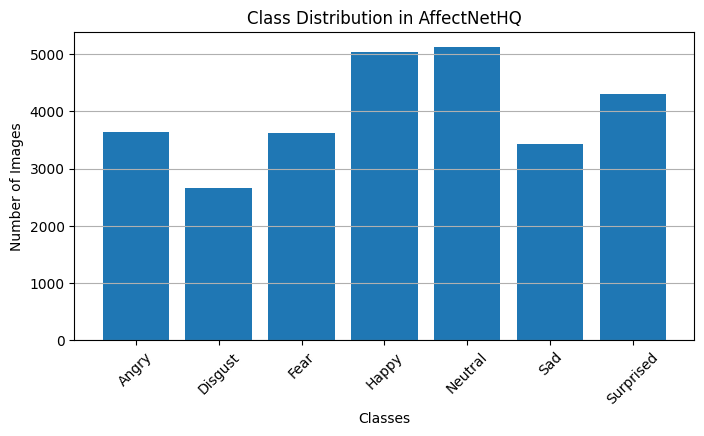

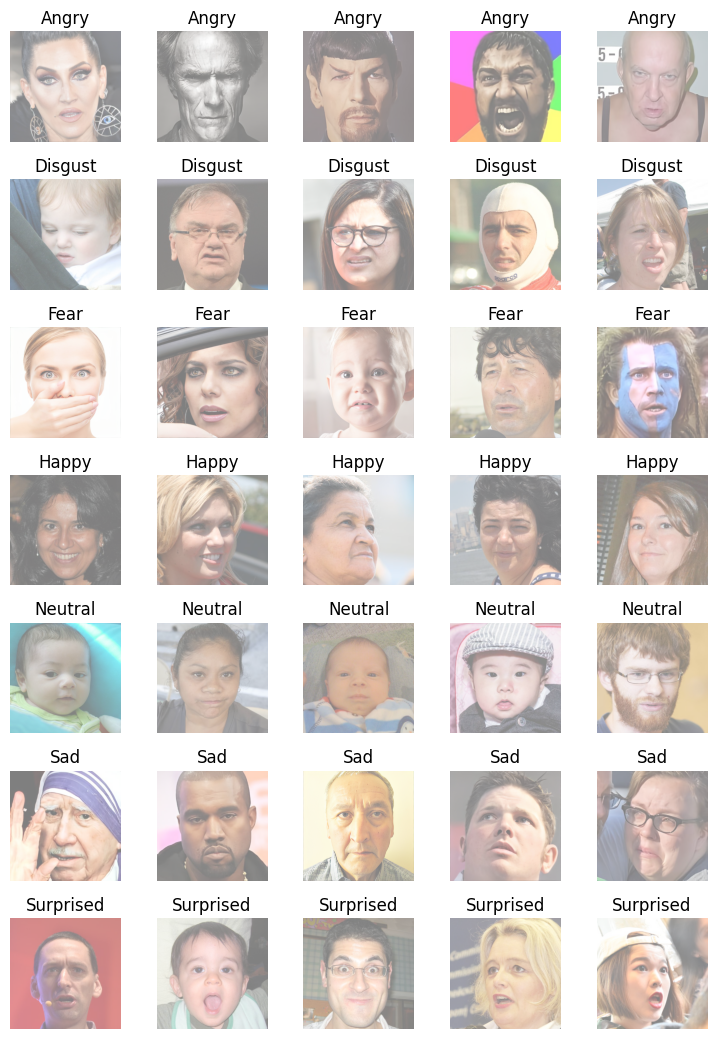

In [7]:
dataset_analysis.get_dataset_stats(dataset)
dataset_analysis.plot_class_distribution(dataset)
dataset_analysis.show_samples_per_class(dataset, samples_per_class=5)

### Dataloader

In [10]:
# Load dataset
batch_size = 16
img_size = 128

train_loader, val_loader, test_loader = dataloader.create_dataloaders(
    img_dir=root_dir,
    batch_size=batch_size,
    val_split=0.1,
    test_split=0.1,
    img_size=img_size
)

# Sanity check
images, labels = next(iter(train_loader))

class_names = train_loader.dataset.dataset.classes
label_indices = labels[:8].tolist()
label_names = [class_names[i] for i in label_indices]

print(f"Batch shape: {images.shape}")
print(f"Label sample (indices): {label_indices}")
print(f"Label sample: {label_names}")

Batch shape: torch.Size([16, 3, 128, 128])
Label sample (indices): [4, 6, 3, 0, 3, 4, 6, 6]
Label sample: ['Neutral', 'Surprised', 'Happy', 'Angry', 'Happy', 'Neutral', 'Surprised', 'Surprised']


**Model Setup**

In [ ]:
!git clone https://github.com/clovaai/stargan-v2.git ../model/starganv2
!chmod u+x ../model/starganv2/download.sh
!../model/starganv2/download.sh pretrained-network-celeba-hq
!mv expr ../model/starganv2/
!mv ../model/starganv2/expr/checkpoints/* ../model/pretrained/ -y

In [ ]:
sys.path.append("../model/starganv2")
from core.solver import Solver
from core.checkpoint import CheckpointIO
import argparse

In [ ]:
# Custom setup
batch_size = 16
img_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader, val_loader, _ = create_dataloaders(
    img_dir=root_dir,
    batch_size=batch_size,
    val_split=0.1,
    test_split=0.1,
    img_size=img_size,
    num_workers=4
)

# Build your training config as a mock `argparse.Namespace`
class Args:
    def __init__(self):
        self.mode = 'train'
        self.img_size = img_size
        self.num_domains = 7
        self.latent_dim = 16
        self.style_dim = 64
        self.batch_size = batch_size
        self.total_iters = 200000
        self.resume_iter = 100000
        self.device = device
        self.checkpoint_dir = "../model/pretrained"
        self.sample_dir = "../results/samples"
        self.log_dir = "../results/logs"
        self.w_hpf = 0
        self.lambda_reg = 1
        self.lambda_sty = 1
        self.lambda_ds = 1
        self.lambda_cyc = 1
        self.lr = 1e-4
        self.f_lr = 1e-6
        self.beta1 = 0.0
        self.beta2 = 0.99
        self.weight_decay = 1e-4

args = Args()

# Instantiate the solver and train
solver = Solver(args)

loaders = Munch(
    src=train_loader,
    ref=train_loader,  # we reuse the same loader for reference-based synthesis
    val=val_loader
)
solver.train(loaders)

In [ ]:
# Instantiate models
G = model.Generator(img_size=256, style_dim=64, w_hpf=1)
D = model.Discriminator(img_size=256, num_domains=7)  # 7 expressions

# Move to GPU
G = G.to(device)
D = D.to(device)

In [ ]:
# Load pre-trained weights
checkpoint = torch.load('../model/pretrained/starganv2_pretrained.pth')
G.load_state_dict(checkpoint['generator'], strict=False)

print("Loaded pre-trained Generator weights successfully!")

### Train the model

In [ ]:
# Create your config
args = train.TrainConfig(
    data_dir='../data/affectnethq',
    save_dir='../results',
    pretrained_path='../model/pretrained/starganv2_pretrained.pth',
    num_epochs=100,        
    batch_size=32,
    learning_rate=2e-4,
)

# Start training
train.train(args)

In [ ]:
# Save manually final model after training
#torch.save(G.state_dict(), '../results/final_generator.pth')
#torch.save(D.state_dict(), '../results/final_discriminator.pth')

## **Experimental Results**
Describe here the main experimental results. Critically discuss them. Compare them with results available in the literature (if applicable).

In this section, you can add **text** and **figures**, **tables**, **plots**, and code. Make sure the code is runnable and replicable.

## **Conclusions**

Summarize what you could and could not conclude based on your experiments.
In this section, you can add **text**.



## **References**
You can add here the citations of books, websites, or academic papers, etc.

In [ ]:
# torch.cuda.empty_cache()
# del net
# del cifar10
# del resnet
# del train_loader

# gc.collect()